# Figure 2: Robustness of the method

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import statistics
from  tqdm import tqdm
import scipy.stats as ss
from single_sample_gsea import ss_gsea as ssGSEA
from matplotlib.colors import to_rgb

import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from calculate_ssGSEA_scores import get_hallmark_genesets

In [2]:
PROJECT = "HNSC"

expressions = pd.read_csv(f"../TCGA/TCGA-{PROJECT}-expressions.tsv", sep="\t", index_col=[0])
expressions.index.name = "gene"
ssgsea = pd.read_csv(f"../TCGA/TCGA-{PROJECT}-ssGSEA.tsv", sep="\t", index_col=[0])
metadata = pd.read_csv(f"../TCGA/TCGA-{PROJECT}-metadata.tsv", sep="\t", index_col=[0])

### Functions

In [19]:
def normalize(expressions):
    exp = np.log(expressions.T + 1)
    exp = (exp - exp.mean(axis=0)) / exp.std(axis=0)
    exp = exp.dropna(axis=1)
    exp = exp.fillna(0)
    return exp.T

def calculate_ssGSEA(expressions, genesets):
    exp = expressions.copy()
    exp = normalize(exp)
    return ssGSEA(exp, genesets)

In [4]:
def bootstrap_logrank_values(ssgsea, metadata, M_BOOTSTRAP, geneset, seed=0, fraction_of_samples=1):
    np.random.seed(seed)

    s = ssgsea[geneset].to_frame()
    m = metadata.loc[s.index.values]

    bootstrap_values = []

    for _ in tqdm(range(M_BOOTSTRAP)):

        ids = np.random.choice(np.arange(len(s)), size=int(len(s)*fraction_of_samples), replace=True)
        s_boot = s.iloc[ids]
        m_boot = m.iloc[ids]

        up_ids = s_boot[geneset] > np.median(ssgsea[geneset])
        up_score = m_boot.loc[up_ids]
        down_score = m_boot.loc[~up_ids]

        bootstrap_values += [
            statistics.logrank_test(
                up_score["time"], down_score["time"],
                event_observed_A=up_score["event"], event_observed_B=down_score["event"]
            )
        ]
    
    return bootstrap_values

def bootstrap_CI(ssgsea, metadata, M_BOOTSTRAP, geneset, seed=0):

    bootstrap_values = bootstrap_logrank_values(ssgsea, metadata, M_BOOTSTRAP, geneset, seed)

    return np.percentile(bootstrap_values, 2.5), np.percentile(bootstrap_values, 97.5)

In [5]:
def downsample_and_evaluate(ssgsea, metadata, geneset, fraction=1):

    s = ssgsea[geneset].to_frame().sample(int(len(ssgsea)*fraction))
    m = metadata.loc[s.index.values]

    up_ids = s[geneset] > np.median(s[geneset])
    up_score = m.loc[up_ids]
    down_score = m.loc[~up_ids]

    return statistics.logrank_test(
        up_score["time"], down_score["time"],
        event_observed_A=up_score["event"], event_observed_B=down_score["event"]
    )

def downsampled_geneset(geneset_genes, n_genes):
    return np.random.choice(geneset_genes, size=min(n_genes, len(geneset_genes)), replace=False)

def replace_genes_in_geneset(complete_geneset, all_genes, n_genes_in):

    np.random.shuffle(complete_geneset)
    LEN = len(complete_geneset)
    still_in_geneset = list(complete_geneset[:min(n_genes_in, LEN)])

    rest_genes = list(np.random.choice(list(set(all_genes).difference(still_in_geneset)), size=LEN-len(still_in_geneset), replace=False))

    return still_in_geneset + rest_genes


## Generating data

In [31]:
def downsample_and_evaluate(ssgsea, metadata, geneset, fraction=1):

    s = ssgsea[geneset].to_frame().sample(int(len(ssgsea)*fraction))
    m = metadata.loc[s.index.values]

    up_ids = s[geneset] > np.median(s[geneset])
    up_score = m.loc[up_ids]
    down_score = m.loc[~up_ids]

    return statistics.logrank_test(
        up_score["time"], down_score["time"],
        event_observed_A=up_score["event"], event_observed_B=down_score["event"]
    )

def downsampled_geneset(geneset_genes, n_genes):
    return np.random.choice(geneset_genes, size=min(n_genes, len(geneset_genes)), replace=False)

def replace_genes_in_geneset(complete_geneset, all_genes, n_genes_in):

    np.random.shuffle(complete_geneset)
    LEN = len(complete_geneset)
    still_in_geneset = list(complete_geneset[:min(n_genes_in, LEN)])

    rest_genes = list(np.random.choice(list(set(all_genes).difference(still_in_geneset)), size=LEN-len(still_in_geneset), replace=False))

    return still_in_geneset + rest_genes


In [32]:
# PARAMETERS
testing_geneset = "HALLMARK_GLYCOLYSIS"

M_BOOTSTRAP = 1000
NORMALIZE = True

In [33]:
# create genesets
np.random.seed(1)

hallmark_genesets = get_hallmark_genesets(expressions.index.values, "..")

In [34]:
complete_geneset = list(hallmark_genesets[testing_geneset])
np.random.shuffle(complete_geneset)

STEP = int(len(complete_geneset)//5)

GENESETS = {}

for i in range(6):
    genes = complete_geneset[:STEP*i] if i != 5 else complete_geneset
    random_genes = np.random.choice(expressions.index.values, STEP*(5-i), replace=False)
    GENESETS[f"random_{100 - 20*i}"] = set(list(genes) + list(random_genes))

In [35]:
# calculate ssGSEA
ssgsea = calculate_ssGSEA(expressions, GENESETS)

In [36]:
# values for plotting

geneset_bootstrap_values = {
    geneset: bootstrap_logrank_values(ssgsea, metadata, M_BOOTSTRAP if geneset != "random_0" else 1, geneset, 0)
    for geneset in GENESETS.keys()
}

100%|██████████| 1/1 [00:00<00:00, 16.79it/s]


In [37]:
### SAMPLE DOWNSAMPLING
M_DOWNSAMPLE = 100

downsample_bootstrap_values = {
    frac: [downsample_and_evaluate(ssgsea, metadata, "random_0", fraction=frac/100) for _ in range(M_DOWNSAMPLE)]
    for frac in [50, 60, 70, 80, 90, 100] 
}
downsample_stats = {
    frac: [x.test_statistic for x in values]
    for frac, values in downsample_bootstrap_values.items()
}

In [39]:
## SAMPLE DOWNSAMPLING
M_DOWNSAMPLE_SETS = 30

complete_geneset = list(hallmark_genesets[testing_geneset])
N = 200
down_genes = [40*(i+1) for i in range(4)]

GENESETS = {"geneset_200_0": complete_geneset}

for n_genes in down_genes:
    for i in range(M_DOWNSAMPLE_SETS):
        GENESETS[f"geneset_{n_genes}_{i}"] = downsampled_geneset(complete_geneset, n_genes=n_genes)
    
down_ssgsea = calculate_ssGSEA(expressions, GENESETS)

In [40]:
downgene_bootstrap_values = {
    geneset: downsample_and_evaluate(down_ssgsea, metadata, geneset, fraction=1)
    for geneset in GENESETS.keys()
}

downgene_stats = {x: [] for x in down_genes + [200]}

for key, value in downgene_bootstrap_values.items():
    downgene_stats[int(key.split("_")[1])] += [value.test_statistic]


In [42]:
## RANDOM GENE REPLACEMENT
M_RANDOM_GENES = 100

complete_geneset = list(hallmark_genesets[testing_geneset])
N = 200
down_genes = [40*(i) for i in range(5)]

GENESETS = {"geneset_200_0": complete_geneset}

for n_genes in down_genes:
    for i in range(M_DOWNSAMPLE_SETS):
        GENESETS[f"geneset_{n_genes}_{i}"] = replace_genes_in_geneset(complete_geneset, expressions.index.values, n_genes_in=n_genes)
    
down_ssgsea = calculate_ssGSEA(expressions, GENESETS)

In [43]:
replace_bootstrap_values = {
    geneset: downsample_and_evaluate(down_ssgsea, metadata, geneset, fraction=1)
    for geneset in GENESETS.keys()
}

replace_stats = {x: [] for x in down_genes + [200]}

for key, value in replace_bootstrap_values.items():
    replace_stats[int(key.split("_")[1])] += [value.test_statistic]

## Plotting

### Plotting functions

In [44]:
def plot_random_genes(replace_stats, ax, labels_fontsize=11):

    for frac, values in replace_stats.items():
        
        c = to_rgb("k") + (0.8, )
        ax.scatter([100-frac/2], np.median(values), color="orangered" if frac==200 else c, zorder=2, s=20, label=None if frac != 0 else "median")
        ax.plot([100-frac/2, 100-frac/2], [np.percentile(values, 2.5), np.percentile(values, 97.5)], zorder=3, color=c, lw=2, label=None if frac != 0 else "95% CI")
    
    ax.set_xlabel("% of random genes in a geneset", fontsize=labels_fontsize)
    ax.legend(frameon=False, fontsize=labels_fontsize, labelspacing=0.25, borderpad=0)


def plot_downsample(dowsample_stats, ax, labels_fontsize=11):

    for frac, values in dowsample_stats.items():

        c = to_rgb("k") + (0.8, )
        ax.scatter([frac], np.median(values), color="orangered" if frac==100 else c, zorder=2, s=20)
        ax.plot([frac, frac], [np.percentile(values, 2.5), np.percentile(values, 97.5)], zorder=3, color=c, lw=2)

    ax.set_xlabel("% of samples in a dataset", fontsize=labels_fontsize)

def plot_downgene(downgene_stats, ax, labels_fontsize=11):

    for frac, values in downgene_stats.items():

        c = to_rgb("k") + (0.8, )
        ax.scatter([frac], np.median(values), color="orangered" if frac==200 else c, zorder=2, s=20)
        ax.plot([frac, frac], [np.percentile(values, 2.5), np.percentile(values, 97.5)], zorder=3, color=c, lw=2)

    ax.set_xlabel("no. of genes in a geneset", fontsize=labels_fontsize)

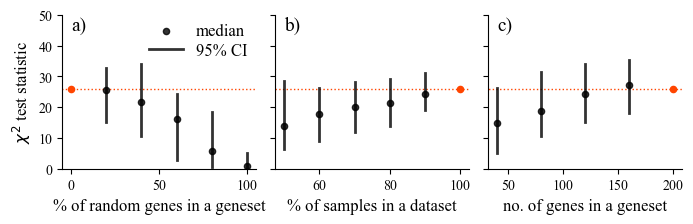

In [45]:
try:
    plt.rcParams["font.family"] = "Times New Roman"
except Exception as e:
    print(e)
    print("Unable to load 'Times New Roman' font. Continuing with default.")

f, ax = plt.subplots(1, 3, figsize=(8, 2), sharey=True, gridspec_kw={"wspace":0.1})

for i in range(3):
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)

LABEL_FONTSIZE = 12

plot_random_genes(replace_stats, ax[0], LABEL_FONTSIZE)

plot_downsample(downsample_stats, ax[1], LABEL_FONTSIZE)

plot_downgene(downgene_stats, ax[2], LABEL_FONTSIZE)

abc = list("abc")
loc = [0, 50, 40]
for i in range(3):
    ax[i].axhline(downsample_stats[100][0], -100, 100, ls="dotted", lw=1, color="orangered", zorder=0)
    ax[i].text(loc[i], 45, f"{abc[i]})", fontsize=LABEL_FONTSIZE+2)

ax[0].set_ylim((0,50))
ax[0].set_ylabel("$\chi^2$ test statistic", fontsize=LABEL_FONTSIZE)

f.savefig("../figures/figure2.png", dpi=300, bbox_inches="tight")